macros latex
$$ 
\def\R{{\mathbb R}} 
\def\x{{\bf x}}
\def\y{{\bf y}}
\def\a{{\bf a}}
\def\w{{\bf w}}
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn as sk
from sklearn.linear_model import LinearRegression
import sklearn.datasets

# Perceptron : modèle et algorithme

## Classification
Un **problème de classification** est un problème d'apprentissage supervisé où les étiquettes cibles à prédire sont prennent des valeurs binaires. Dans un problème de **classification binaire** il n'y a que deux classes et on peut supposer les données de la forme
$${\cal D} = \{ (x^i,y^i) \}_{1 \leq i \leq m}$$
avec $x^i \in \R^d$ et $y^i \in \{-1, +1 \}$  
(on peut parfois aussi considérer les classes $1$ et $0$ au lieu de $1$ et $-1$).

### Exemple en dimension 1  
On cherche à prédire la race d'un chien suivant sa masse.  
Classe -1 : Caniche (12kg en moyenne)
Classe 1 : Dobermann (42 kg en moyenne)

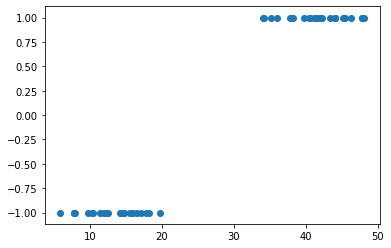

In [2]:
can = np.random.normal(12,3,25)
dob = np.random.normal(42,4,25)
X = np.concatenate((can, dob))
Y = np.array([-1]*25 + [1]*25)
plt.scatter(X,Y)
plt.show()

Essayons de classifier avec la régression linéaire

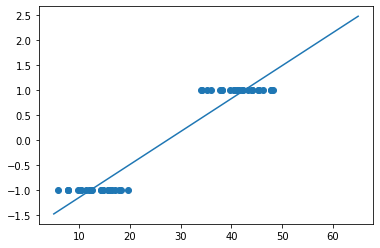

In [3]:
Xr = X.reshape(-1,1)
lin_reg = LinearRegression()
lin_reg.fit(Xr,Y)
Xlin = np.linspace(5,65,200)
plt.plot(Xlin,lin_reg.predict(Xlin.reshape(-1,1)))
plt.scatter(X,Y)
plt.show()

On voit que la regression linéaire en dimension 1 n'est pas du tout adaptée pour séparer les classes. 

### Exemples en dimension 2

In [5]:
iris = sk.datasets.load_iris()
print(dir(iris))
print(iris['feature_names'])
print(iris['target_names'])

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


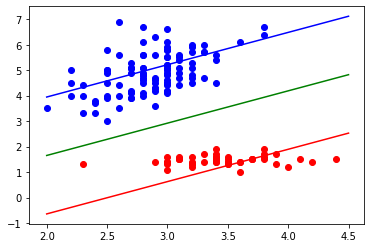

In [5]:

Xiris = iris.data[ :, 1:3] #deux colonnes largeur sepale + longueur petale
Yiris = iris.target
rename = lambda x : 1 if x == 0 else -1
rename = np.vectorize(rename)  #transforme une fonction en une fonction pouvant s'appliquer aux tableaux point par point
Yiris = rename(Yiris)
plt.scatter(Xiris[Yiris==1][:,0],Xiris[Yiris==1][:,1],c='red')
plt.scatter(Xiris[Yiris==-1][:,0],Xiris[Yiris==-1][:,1],c='blue')
lin_reg.fit(Xiris,Yiris)
Xlin = np.linspace(2,4.5,200)
a1,b1 = lin_reg.coef_  
c = lin_reg.intercept_ 
plt.plot(Xlin, -c/b1 - a1/b1*Xlin , c='green')       #a1 x + b1 y + c = 0 
plt.plot(Xlin, (1-c)/b1 - a1/b1*Xlin , c= 'red')    #a1 x + b1 y + c = 1 
plt.plot(Xlin, (-1-c)/b1 - a1/b1*Xlin, c='blue' )   #a1 x + b1 y + c = -1 
plt.show()

Sur cet exemple cela se passe bien car les deux classes de données sont poids et "taille" dans l'espace sensiblement égales.

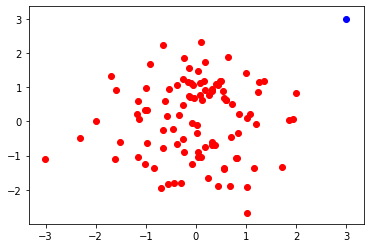

In [6]:
X1 = np.random.multivariate_normal([0,0],[[1,0],[0,1]],100)
X1 = np.concatenate( (X1, np.array([[3,3]])), axis=0 )
Y1 = np.array([1]*100 + [-1])
plt.scatter(X1[Y1==1][:,0],X1[Y1==1][:,1],c='red')
plt.scatter(X1[Y1==-1][:,0],X1[Y1==-1][:,1],c='blue')
plt.show()

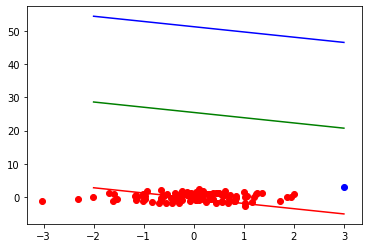

In [7]:
lin_reg.fit(X1,Y1)
Xlin = np.linspace(-2,3,200)
a1,b1 = lin_reg.coef_  
c = lin_reg.intercept_
plt.scatter(X1[Y1==1][:,0],X1[Y1==1][:,1],c='red')
plt.scatter(X1[Y1==-1][:,0],X1[Y1==-1][:,1],c='blue')
plt.plot(Xlin, -c/b1 - a1/b1*Xlin , c='green')       #a1 x + b1 y + c = 0 
plt.plot(Xlin, (1-c)/b1 - a1/b1*Xlin , c= 'red')    #a1 x + b1 y + c = 1 
plt.plot(Xlin, (-1-c)/b1 - a1/b1*Xlin, c='blue' )   #a1 x + b1 y + c = -1
plt.show()

Bilan : la regression linéaire n'est pas pas du tout adaptée à la classification, même pour les données qui sont pourtant *linéairement séparables*.

## Modèle du perceptron, un classificateur linéaire

L'algorithme du Perceptron (Rosenblatt 1957) est un algorithme de *classification linéaire* qui est un modèle élémentaire de neurone.

<img src="images/neurone_bio.png" width=500 alt="neurone biologique">


<img src="images/neurone_bio.png" width=500 alt="neurone biologique">
<img src="images/neurone_art.png" width=500 alt="neurone artificiel">

Le perceptron est un modèle (et un algorithme) pour la classification. On a des données de la forme $(x^i,y^i)$ pour $i$ de 1 à $m$ où $y^i \in \{+1, -1\} $ est l'image de $x^i \in \R^d$ par une fonction inconnue que l'on cherche à approximer.  
Les données appartiennent donc à deux *classes* notées $+1$ et $-1$ et le perceptron doit apprendre à prédire cette classe $y^i$ en fonction de $x^i$.

Le modèle du perceptron, comme la régression linéaire, est *paramétrique*. Les *hypothèses* sont les fonctions
$$h_\w : \R^d \rightarrow \{+1,-1\}$$
  
  où $\w$ est un *vecteur de poids* (paramètres) $\w=(w_1,w_2,\dots,w_d) \in \R^d$ et biais $b \in \R$

  On prédit

  $h(\x) = 1$ si $\sum_{i=1}^d w_i x_i + b \geq 0$
  
  $h(\x) = -1$ si $\sum_{i=1}^d w_i x_i + b < 0$

soit 
  $$h(\x) = \text{signe}(\langle \x,\w \rangle + b) $$




On peut noter $\hat{y}$ la prédiction finale, à comparer à la cible $y$, et $z = \langle \w, \x \rangle + b$ l'aggregation linéaire de la prédiction. Le calcul peut être vu comme un pipeline (à $w$ fixé)
$$ \boxed{x \longmapsto z = \langle \w, \x \rangle + b \longmapsto \hat{y} = \text{signe}(z)}$$

<img src="images/percep1.png" width=500 alt="separation plan par perceptron">

Comme dans le cas de la régression, on augmente la dimension des données avec une coordonnée $x^i_0 = 1$ et on pose $w_0 = b$ de sorte de se ramener à une expression linéaire :
$$h(\x) = \text{signe}(\sum_{i=1}^d w_i x_i + b) = \text{signe}(\sum_{i=0}^d w_i x_i ) $$


On dit que l'échantillon ${\cal D} = \{ (x^i,y^i)_{1 \leq i \leq m}\} $ est *linéairement séparable* s'il existe un hyperplan séparant les deux classes $1$ et $-1$, autrement dit s'il existe $\w$ et $b$ tels que $h_\w(x^i) = y^i$.
Ceci revient à dire aussi qu'il existe un vecteur $\w$ tel que
$$y^i \cdot \langle w, x^i \rangle > 0$$
pour tout $i$.

In [2]:
X0=np.array([[1,-1],[3,2],[1,3],[-1,1],[1,5],[-1,4],[-2,2]])
Y0=np.array([-1,-1,-1,-1,1,1,1])

def visualiser_points(X,Y):
        """représente les points de l'échantillon et leur classe en deux couleurs
        """
        plt.scatter(x=X[Y == 1, 0], y=X[Y == 1, 1], c='green', marker='o', edgecolor='black')
        plt.scatter(x=X[Y == -1, 0], y=X[Y == -1, 1], c='red', marker='o', edgecolor='black')
        plt.show()

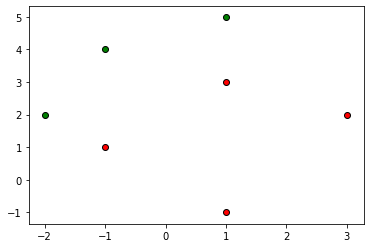

In [3]:
visualiser_points(X0,Y0)

Les points ci-dessus sont clairement linéairement séparables (on peut faire passer strictement une droite entre les points rouges et verts).

## Algorithme du perceptron
Il s'agit d'une règle de mise à jour des poids $\w$ qui va converger vers une solution séparant les classes **dans le cas où les classes sont linéairement séparables**.

*  initialiser $\w = \mathbf{0} = (0,0,\dots,0)$
*  Tant qu'il existe au moins un point $\x^i$, $1 \leq i \leq m$
  qui n'est pas classifié correctement i.e.
  $$ \boxed{y^i \cdot \langle \w, \x^i \rangle \leq 0}$$ 
  * choisir un tel $\x^i$ mal classifié
  * mettre à jour
  $$\boxed{\w \leftarrow \w + y^i \cdot \x^i}$$



  *Intuition de la mise à jour*  
  Si $\x^i$ est mal classifié, $y^i \neq h(\x^i)$ soit $y^i \cdot \langle
  \x^i,\w \rangle < 0$

  Le nouveau $\w'= \w + y^i \cdot \x^i$ est donc tel que


  \begin{align*}
    y^i \cdot \langle \w',\x^i \rangle  &= y^i \cdot \langle \w  + y^i \cdot \x^i ,\x^i \rangle \\
    &= y^i \cdot \langle \w,\x^i \rangle + (y^i)^2 \cdot \langle \x^i, \x^i \rangle \\
    &> y^i \cdot \langle \w,\x^i  \rangle   
  \end{align*} 

  va donc faire évoluer la classification de $\x^i$ dans le sens souhaité ($\x^i = 0$ est exclus car les $x^i$
  ont $1$ sur la première coordonnée).

  **Théorème** Si l'échantillon $(\x^i,y^i)_{1 \leq i \leq m}$ est linéairement séparable,
    alors en un nombre fini d'étapes l'algorithme du perceptron va se terminer avec un vecteur de poids $\w$
    qui sépare les données.
  
  NB : Le résultat final obtenu dépend de l'ordre dans lequel les points mal
  classifiés   sont considérés.

In [16]:
class Perceptron:
    
    def __init__(self):
        self.w = None #vecteur de poids, w[0] contient le biais
        
    def prediction(self,x):
        """une fois le perceptron entraîné, prédit la valeur sur un point
        ici x est un vecteur non augmenté (on a pas mis de 1 en coordonnée 0)"""
        return 1 if (self.w[0] + np.dot(self.w[1:],x) >=0) else -1
    
    def entrainement(self, X, Y, nb_etapes_max = 10000, rapport = False, liste = None):
        """X est un jeu de données d-dimensionnelles (np.arrays) 
        (non augmentées de 1 pour le biais)
        Y est l'ensemble des valeurs +1/-1 correspondantes
        Y[i] est la classe de X[i]
        L'algorithme du perceptron va tourner au maximum
        sur le nombre d'étapes données jusqu'à convervence
        Si liste==True , renvoie la liste des poids w successifs"""
        
        etape = 0 # compteur d'étapes
        en_cours = True

        
        #initialisation des poids à 0
        self.w = np.array([0]*(1+len(X[0])), dtype=float)
        if liste:
            liste_w = [np.copy(self.w)]
        else:
            liste_w = None
            
        while en_cours and etape < nb_etapes_max:
            #recherche du premier point mal classifié
            i = 0
            while i< len(X) and self.prediction(X[i]) == Y[i]:
                #le point est bien classé
                i += 1
            
            if i==len(X):
                #tous les points sont bien classifiés 
                en_cours = False
                break
            else:
                #X[i] est mal classifié
                
                self.w[0] += Y[i]
                self.w[1:] += Y[i]*X[i]
                if liste:
                    liste_w.append(np.copy(self.w))
                
            etape += 1
            
        if rapport:
            if etape < nb_etapes_max:
                print("Nombre d'étapes pour convergence :", etape)
            else:
                print("pas de convergence")
        return liste_w

## Exemples
### jeu de données X0 (7 points)

In [11]:
p = Perceptron()
liste_w = p.entrainement(X0,Y0, rapport=True, liste=True)
#affichage du vecteur obtenu
print(p.w)

Nombre d'étapes pour convergence : 18
[-8. -4.  3.]


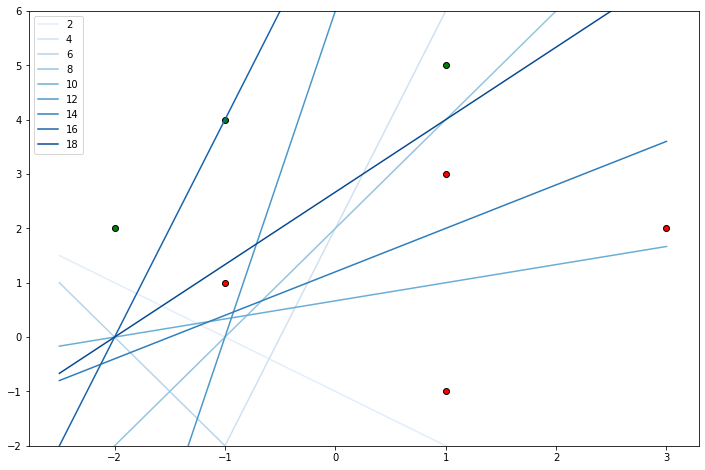

In [12]:
plt.figure(figsize=(12,8))
plt.ylim((-2,6))
plt.scatter(x=X0[Y0 == 1, 0], y=X0[Y0 == 1, 1], c='green', marker='o', edgecolor='black')
plt.scatter(x=X0[Y0 == -1, 0], y=X0[Y0 == -1, 1], c='red', marker='o', edgecolor='black')
blues = plt.get_cmap('Blues')  # this returns a colormap
Xlin = np.linspace(-2.5,3,200)
for i in range(2,len(liste_w),2):
    w = liste_w[i]
    if w[2] != 0:
        Y = -w[1]/w[2]*Xlin - w[0]/w[2]    # w1 x1 + w2 x2 + w0=0
        plt.plot(Xlin,Y, label = i, color = blues(i/20))
plt.legend()
plt.show()

In [13]:
def visualisation_zones(perc,X,Y,label= "", transformation = None):
    """pour un perceptron perc ayant été entraîné,
    représente les points de l'échantillon (X,Y) et les
    zones de décision suivant la valeur actuelle de perc.w """

    #on récupère les coordoonées minimales et maximales présentes
    #dans X sur les axes x1 et x2
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    #on crée une liste de points qui maillent tout le rectangle
    #defini par les valeurs min et max obtenues
    resolution = 0.1
    abscisses = np.arange(x1_min, x1_max, resolution)
    ordonnees = np.arange(x2_min, x2_max, resolution)
    abs_grille, ord_grille = np.meshgrid(abscisses,ordonnees)
    points = np.array([abs_grille.ravel(), ord_grille.ravel()]).T
    if transformation:
        points = transformation(points)
    #valeurs de classification associées à chaque point
    val_points = np.array([perc.prediction(p) for p in points])

    #on place les points X de X dans le graphique
    plt.xlim(abs_grille.min(), abs_grille.max())
    plt.ylim(ord_grille.min(), ord_grille.max())

    cmap = ListedColormap(['tomato','lightgreen'])
    plt.contourf(abs_grille,ord_grille, val_points.reshape(abs_grille.shape), \
                 cmap=cmap, alpha=1)

    plt.scatter(x=X[Y == 1, 0], y=X[Y == 1, 1],
        alpha=1, c='green',
        marker='o', edgecolor='black')

    plt.scatter(x=X[Y == -1, 0], y=X[Y == -1, 1],
        alpha=1, c='red',
        marker='o', edgecolor='black')
    plt.title("vert=1, rouge=-1 "+ label)

    plt.show()

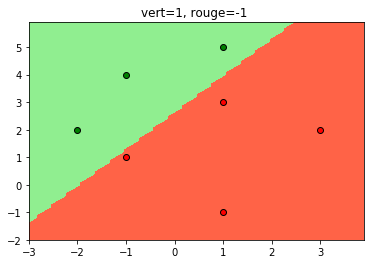

In [14]:
visualisation_zones(p,X0,Y0)

On vérifie bien que le vecteur obtenu sépare linéairement les données.

### jeu de données iris

In [6]:
print(iris['target_names'])

['setosa' 'versicolor' 'virginica']


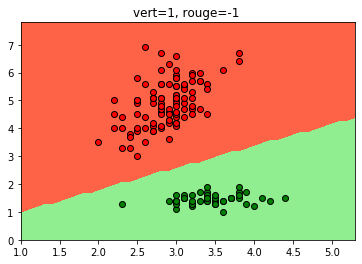

In [20]:
p = Perceptron()
p.entrainement(Xiris,Yiris)
visualisation_zones(p,Xiris,Yiris)

### jeu de données X1 (où la regression linéaire a échoué)

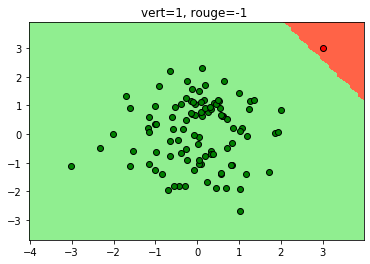

In [21]:
p.entrainement(X1,Y1)
visualisation_zones(p,X1,Y1)

Ici l'algorithme du perceptron est parvenu à classifier les données contrairement à la régression linéaire.

### Exemple en dimension supérieure 

In [22]:
data_wine = sk.datasets.load_wine()
print(dir(data_wine))
print(data_wine['feature_names'])
print(data_wine['target_names'])
Xwine = data_wine.data

# on va utiliser les classes 1 et 2 comme classe 1 et 0 comme classe -1
rename = lambda x : -1 if x == 0 else 1
rename = np.vectorize(rename)
Ywine = rename(data_wine['target'])

['DESCR', 'data', 'feature_names', 'target', 'target_names']
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


In [23]:
print(Xwine[:5,:])
print(Ywine[:5])
print(len(Xwine), len(Ywine))

[[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
  2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 1.120e+01 1.000e+02 2.650e+00 2.760e+00
  2.600e-01 1.280e+00 4.380e+00 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 1.860e+01 1.010e+02 2.800e+00 3.240e+00
  3.000e-01 2.810e+00 5.680e+00 1.030e+00 3.170e+00 1.185e+03]
 [1.437e+01 1.950e+00 2.500e+00 1.680e+01 1.130e+02 3.850e+00 3.490e+00
  2.400e-01 2.180e+00 7.800e+00 8.600e-01 3.450e+00 1.480e+03]
 [1.324e+01 2.590e+00 2.870e+00 2.100e+01 1.180e+02 2.800e+00 2.690e+00
  3.900e-01 1.820e+00 4.320e+00 1.040e+00 2.930e+00 7.350e+02]]
[-1 -1 -1 -1 -1]
178 178


In [39]:
p1 = Perceptron()
p1.entrainement(Xwine, Ywine, nb_etapes_max=500000)


In [51]:
print("misclassifiés", sum([ p1.prediction(Xwine[i]) != Ywine[i] for i in range(len(Xwine))]))

misclassifiés 14


En 500000 étapes on ne parvient pas à séparer les données ici mais le taux d'erreur devient faible (8%). En fait ce jeu de données **est** linéairement séparable. Il pourrait être profitable de mettre les données à la même échelle (scaling) !

In [52]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_X.fit(Xwine)
Xwine_sc = scaler_X.transform(Xwine)

In [53]:
p2 = Perceptron()
p2.entrainement(Xwine_sc, Ywine, nb_etapes_max=50)
print("misclassifiés", sum([ p2.prediction(Xwine_sc[i]) != Ywine[i] for i in range(len(Xwine_sc))]))

misclassifiés 0


On y arrive en 50 étapes !

## Preuve de convergence de l'algorithme
On se place dans le cas où on part du poids initial $w_0 = 0$.
Puisque les données $(x^i,y^i)$ sont linéairement séparables, il existe par définition une direction $w^*$ tel que pour tout $i$ on ait $y^i \cdot \langle w^*, x^i \rangle > 0$, et on pose
$$ \gamma = \min_{1 \leq i \leq m} y^i \cdot \langle w^*, x^i \rangle,$$
on a alors $\gamma >0$.

D'autre part les $x^i$ étant en nombre fini il existe $R > 0$ tel que 
$$\forall i, \|x^i\| \leq R.$$
(on considère la norme 2 pendant cette preuve).

Rappel : la règle de mise à jour de $w$ est 
$$w \leftarrow w + y^i x^i$$
où $x^i$ vérifie $y^i \cdot \langle w, x^i \rangle < 0$ (mal classifié). 

Soit $w_t$ le vecteur de poids obtenu à l'étape $t$. D'après la règle ci-dessus
$$
\begin{align*}
    \|w_{t+1}\|^2 &= \langle w_{t+1}, w_{t+1} \rangle \\
                  &=  \langle w_t, w_t \rangle +  2 y^i \langle w_t, x^i \rangle + \langle y^i x^i, y^i x^i\rangle  \\
                  &\leq \| w_t \|^2 + R^2
\end{align*}
  $$
 donc par récurrence et comme $w_0 = 0$ on obtient
 $$ \| w_t \|^2 \leq t R^2  $$

D'un autre côté on a
$$
\begin{align*}
    \langle w^*, w_{t+1} \rangle &= \langle w^*, w_t \rangle + y^i \langle w^*, x^i \rangle \\
                                 &\geq  \langle w^*, w_t \rangle + \gamma \\
 \end{align*}
  $$
  d'où par récurrence 
  $$ \langle w^*, w_t \rangle \geq t \gamma $$
  et comme $\langle w^*, w_{t+1} \rangle \leq \|w^*\| \|w_t\| = \|w_t\|$
  on en déduit
  \begin{equation}
    \| w_t \| \geq t \gamma
  \end{equation}


Des deux inéalités sur $\|w_t\|$ on déduit 
$$ t^2 \gamma^2 \leq t R^2 $$
d'où
$$t \leq \frac{\R^2}{\gamma^2}$$
On a donc convergence en au plus ce nombre d'étape. Il apparait que l'algorithme prend d'autant plus de temps que les données sont grandes (R grand) ou sont peu séparables linéairement ($\gamma$ petit).

## Données non linéairement séparables
### le "pocket algorithm"

Si les données ne sont pas séparables, on peut chercher un vecteur $\w$ qui minimise le coût 0-1 (ou taux d'erreur)
$$L_{0,1}(\w) = \frac{| h_\w (x^i) \neq y^i, 1 \leq i \leq m |}{m}$$

In [89]:
def cout_01(p, X_test, Y_test):
    """renvoie le taux entre 0 et 1 d'erreurs du perceptron (déja entrainé)
    sur (X_test,Y_test)"""

    err = 0
    for i in range(len(X_test)):
        if p.prediction(X_test[i]) != Y_test[i]:
            err += 1
    return float(err)/len(X_test)  

In [ ]:
#Génération de 200 points situés de part et d'autre de la parabole y=-2x^2 -x + 3

def echantillon_rect_uniforme_2D(x1_min, x1_max, x2_min, x2_max, taille_echantillon):
    """renvoie un echantillon iid uniformément dans le rectangle donné"""
    X = np.random.random_sample((taille_echantillon,2))
    X[:,0] = X[:,0]*(x1_max-x1_min) + x1_min
    X[:,1] = X[:,1]*(x2_max-x2_min) + x2_min
    return X


Xpar = echantillon_rect_uniforme_2D(-5,5,-5,5,200)
Ypar = np.array([1 if -2*(Xpar[i,0])**2 - Xpar[i,1] + 3 >=0 else -1 for i in range(len(Xpar))])

In [ ]:
visualiser_points(Xpar, Ypar)

In [ ]:
#on vérifie que l'algo du perceptron ne converge pas
p.entrainement(Xpar,Ypar, rapport=True)

In [ ]:
visualisation_zones(p,Xpar,Ypar)

In [ ]:
cout_01(p,Xpar,Ypar)

Soit 24.5% des données mal classifiées.

Le **"pocket algorithm"** : on garde simplement la trace au cours de l'algorithme du perceptron du vecteur de poids $\w$ qui a donnée le meilleur taux d'erreur !

In [84]:
#fonction qu'on va ajouter au preceptron en méthode 
def f(p, X, Y, nb_etapes = 1000):
        """idem que entrainement mais garde en mémoire les diffents
        w obtenus et garde au final celui qui a le taux d'erreur
        le plus bas.
        NB : pour illustration on garde tous les w successifs
        mais on pourrait ne garder que le meilleur pour être plus efficace"""
                
        etape = 0 # compteur d'étapes
        en_cours = True
        

        #initialisation des poids à 0
        p.w = np.array([0]*(1+len(X[0])),dtype=float)
        Ws = [np.copy(p.w)]  #va stocker tous les w successifs
        erreurs = [cout_01(p,X, Y)]
                    
        while en_cours and etape < nb_etapes:
            #recherche du premier point mal classifié
            i = 0
            while i< len(X) and p.prediction(X[i]) == Y[i]:
                #le point est bien classé
                i += 1
            
            if i==len(X):
                #tous les points sont bien classifiés 
                en_cours = False
                break
            else:
                #X[i] est mal classifié
                
                p.w[0] += Y[i]
                p.w[1:] += Y[i]*X[i]
                
                Ws.append(np.copy(p.w))  #va stocker tous les w successifs
                erreurs.append(cout_01(p,X, Y))
            etape += 1
        #on cherche le meilleur et on le met en w courant du perceptron
        i = np.array(erreurs).argmin()
        p.w = Ws[i]
        return Ws

#on ajoute la fonction comme nouvelle méthode au perceptron
Perceptron.meilleur_entrainement = f

In [ ]:
p = Perceptron()
W = p.meilleur_entrainement(Xpar, Ypar, nb_etapes = 500)
cout_01(p,Xpar,Ypar)  #qui est plus faible maintenant en principe !
visualisation_zones(p,Xpar,Ypar)

In [ ]:
# liste des cout_01 successifs
E = []
for w in W:
    p.w = w
    E.append(cout_01(p,Xpar,Ypar))
plt.plot(E)
plt.show()

Comme on le voit dans le cas non linéairement séparable on ne peut pas dire que l'algorithme s'approche d'une solution meilleure car il continue à osciller.

### Augmentation de la dimension
Comme pour la regression linéaire, on peut procéder à une augmentation de la dimension des données en ajoutant des caractéristiques quadratiques, cubiques, etc. et entraîner un perceptron en plus haute dimension.

In [ ]:
def quadratiser_donnees_2d(X):
    c1 = (X[:,0]**2).reshape(len(X),1)
    c2 = (X[:,1]**2).reshape(len(X),1)
    c3 = (X[:,0] * X[:,1]).reshape(len(X),1)
    return np.concatenate((X,c1,c2,c3),axis=1)

In [ ]:
X = np.array([[1,2],[3,4]])
quadratiser_donnees_2d(X)

In [ ]:
Xpar_a = quadratiser_donnees_2d(Xpar)
p = Perceptron()
p.entrainement(Xpar_a, Ypar)
cout_01(p, Xpar_a, Ypar)

In [ ]:
visualisation_zones(p, Xpar, Ypar, transformation = quadratiser_donnees_2d)

On peut plus généralement obtenir une erreur plus faible en augmentant la dimension davantage : degrés 3, 4, etc. Cependant attention plus le modèle devient complexe et plus on est exposés à la suradapation (overfitting).

### Le perceptron comme algorithme de gradient stochastique

L'algorithme du perceptron cherche à minimiser le coût (*loss*) dit *coût 0-1* (aussi appelé taux d'erreur plus haut)
$$L_{0,1}(\w) = \frac{1}{m} \sum_i^m \ell_{0,1}(z^i,\y^i)$$
où 
$$z^i = \langle w, x \rangle$$
$$\ell_{0,1} : \R^2 \rightarrow \R $$
$$ \ell_{0,1}(z,y) = {\mathbb 1}_{z\cdot y \leq 0}$$
Si $z^i = \langle w, x \rangle$ est du bon signe le coût est 0 sinon le cout est 1 (on compte les erreurs de signe donc).

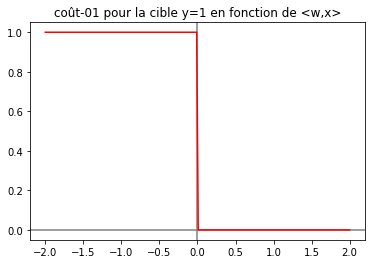

In [64]:
Xlin = np.linspace(-2,2,200)
l01 = lambda z : 0 if z>0 else 1
l01 = np.vectorize(l01)
plt.axhline(color = "gray")
plt.axvline(color = "gray")
plt.plot(Xlin, l01(Xlin),color='red')
plt.title("coût-01 pour la cible y=1 en fonction de z=<w,x>")
plt.show()

Le coût 0-1 a le défaut de n'être pas convexe et d'avoir un gradient nul là où il est défini donc ne permet pas l'optimisation différentielle.

Introduisons le coût "perceptron", qui est une variante du coût de charnière (*hinge loss*) définit par
$$L_{per}(\w) = \frac{1}{m} \sum_{i=1}^m \ell_{per}(\langle \w, \x^i \rangle, \y^i)$$
avec
$$\ell_{per}(z,y) = \max(0, -y\cdot z)$$
soit un coût pour $x^i$ 
$$ \ell_{per}^i = \max(0, -y\cdot \langle \w, \x^i \rangle)$$


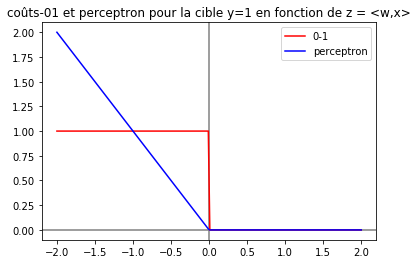

In [65]:
Xlin = np.linspace(-2,2,200)
lper = lambda t : max(0, -t ) ; lper = np.vectorize(lper)
plt.axhline(color = "gray")
plt.axvline(color = "gray")
plt.plot(Xlin, l01(Xlin), color='red', label = "0-1")
plt.plot(Xlin, lper(Xlin), color='blue', label = "perceptron")
plt.title("coûts-01 et perceptron pour la cible y=1 en fonction de z = <w,x>")
plt.legend()
plt.show()

*  si $x^i$ est bien classifié alors $\ell_{per}(z^i, y^i)=0$ 
*  si $x^i$ est mal classifié  alors $$\ell_{per}(z^i, y^i) = - y^i \langle \w,x^i \rangle > 0$$
et c'est une quantité à minimiser.
Le gradient de $\ell^i$ (vu comme une fonction de $\w$) est $0$ si $x^i$ est mal classifié et
$$ \nabla \ell^i(\w) = - y^i x^i $$
sinon. On peut donc interpréter 
  $$\w \leftarrow \w + y^i \cdot \x^i$$
  comme un pas de gradient stochastique (avec pas d'apprentissage $\eta = 1$).
Une technique de gradient stochastique avec le pas qui tend vers 0 de façon bien choisie permettra de converger vers une valeur de $\w$ qui minimise $L_{per}(\w)$ et donc "idéalement" le taux d'erreur.

NB : sur l'hyperplan $\langle \w,x^i \rangle = 0$ la fonction $\ell^i$ est non dérivable, mais utiliser le sous-gradient $0$ permettra d'avoir une convergence comme si c'était le cas.

## Un exemple

In [82]:
data_digits = sklearn.datasets.load_digits()
print(dir(data_digits))
print(data_digits['data'].shape)
print(data_digits['data'][0])
print(data_digits['target_names'], data_digits['target'][0:50])

['DESCR', 'data', 'images', 'target', 'target_names']
(1797, 64)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
[0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 9 5 5 6 5 0
 9 8 9 8 4 1 7 7 3 5 1 0 0]


In [99]:
print(data_digits['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

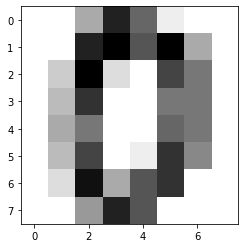

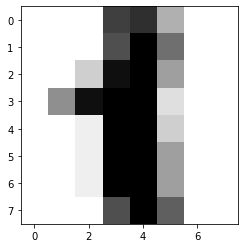

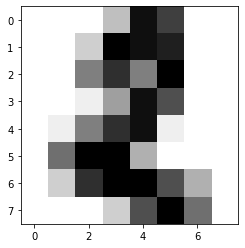

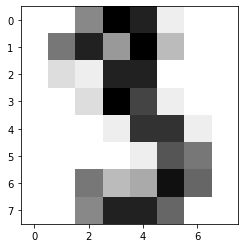

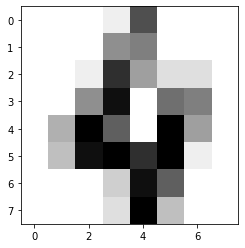

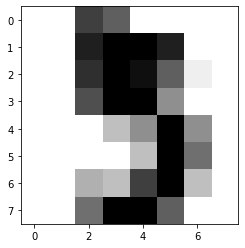

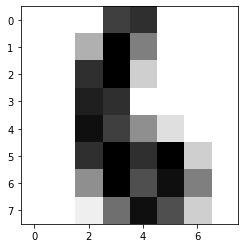

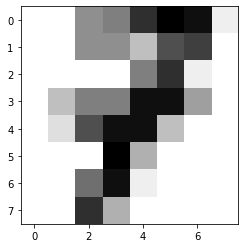

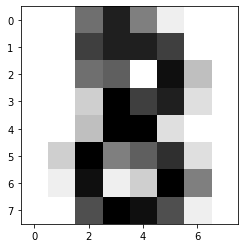

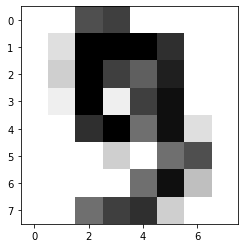

In [76]:
for i in range(10):
    plt.imshow(data_digits['images'][i], cmap=plt.cm.binary, interpolation='nearest')
    plt.show()

In [100]:
Xdig = data_digits['data']
rename = np.vectorize( lambda t,d : 1 if t==d else -1 )
classes_attribuees = {} #dictionnaire index --> classes
for i in range(len(Xdig)):
    classes_attribuees[i] = []
for d in range(10):
    Y = rename(data_digits['target'],d)
    p = Perceptron()
    p.meilleur_entrainement(Xdig, Y, 5000 )
    print('classification du chiffre',d,'cout 0-1',cout_01(p, Xdig, Y))
    for i in range(len(Xdig)):
        if p.prediction(Xdig[i])==1:
            classes_attribuees[i].append(d)

classification du chiffre 0 cout 0-1 0.0
classification du chiffre 1 cout 0-1 0.022259321090706732
classification du chiffre 2 cout 0-1 0.0
classification du chiffre 3 cout 0-1 0.00333889816360601
classification du chiffre 4 cout 0-1 0.0
classification du chiffre 5 cout 0-1 0.0
classification du chiffre 6 cout 0-1 0.0
classification du chiffre 7 cout 0-1 0.0
classification du chiffre 8 cout 0-1 0.037840845854201444
classification du chiffre 9 cout 0-1 0.009460211463550361


In [105]:
erreurs = []
for i in range(len(Xdig)):
    if classes_attribuees[i] != [data_digits['target'][i]]:
        erreurs.append(classes_attribuees[i])
print(len(erreurs)/len(Xdig))
print(erreurs)

0.06844741235392321
[[], [], [], [], [], [], [], [3, 8], [], [], [8, 9], [3, 8], [], [1, 9], [], [], [1, 9], [1, 8], [], [], [], [1], [], [], [], [], [3, 8], [], [], [], [], [], [], [], [2, 8], [], [], [], [], [], [], [], [], [], [8, 9], [], [], [], [1, 5], [], [], [8, 9], [], [], [3, 8], [], [], [], [8], [], [], [], [], [8, 9], [], [], [2, 9], [7, 9], [], [], [], [], [1, 9], [], [], [], [], [], [1, 9], [], [1, 9], [], [], [], [], [], [1, 3], [1], [], [1, 5], [], [], [1, 5], [8, 9], [], [], [1, 3], [3, 8], [1, 4, 9], [1, 5], [1, 4, 9], [1, 9], [1, 8], [], [], [1, 5], [4, 8, 9], [], [], [], [8], [8], [], [], [], [], [], [], [], [], [], [], []]


## La regression logistique (première approche)

Comme on l'a vu la difficulté pour entraîner un perceptron sur un ensemble non-séparant vient du fait que sa fonction d'activation est discontinue (donc non différentiable et non convexe).

In [4]:
signe = lambda x : 1 if x>=0 else -1
signe = np.vectorize(signe)
Xlin = np.linspace(-2,2)
Ysigne = signe(Xlin)

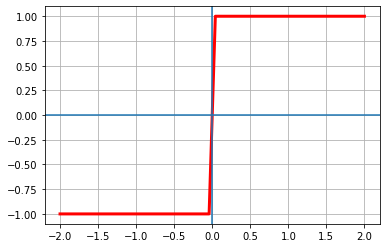

In [9]:
plt.plot(Xlin,Ysigne, color='red', linewidth=3)
plt.grid()       # pour afficher la grille
plt.axhline()    # axe des x
plt.axvline()
plt.show()

Une idée est d'approximer cette fonction par une fonction différentiable. Un bon candidat est la fonction tangente hyperbolique
$$tanh(x) := \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

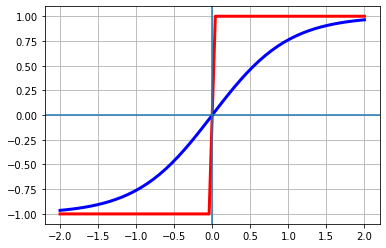

In [11]:
Ytanh = np.tanh(Xlin)
plt.plot(Xlin,Ysigne, color='red', linewidth=3)
plt.plot(Xlin,Ytanh, color='blue', linewidth=3)
plt.grid()       # pour afficher la grille
plt.axhline()    # axe des x
plt.axvline()
plt.show()

Si l'on considère la fonction $x \mapsto \tanh(c\cdot x)$ pour un réel multiplicateur $c$ plus grand on a une meilleure approximation.

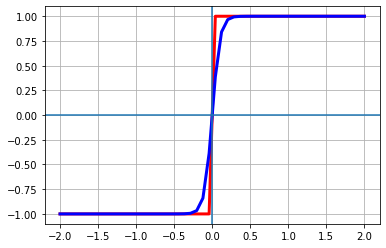

In [12]:
Ytanh2 = np.tanh(10 *Xlin)  #ici c=10
plt.plot(Xlin,Ysigne, color='red', linewidth=3)
plt.plot(Xlin,Ytanh2, color='blue', linewidth=3)
plt.grid()       # pour afficher la grille
plt.axhline()    # axe des x
plt.axvline()
plt.show()

On peut donc chercher à approximer nos cibles $y^i$ par une relation de la forme
$$y^i = \tanh( \langle w, x^i \rangle ) $$

La **regression logistique** consiste à faire cela mais se place dans le cadre où les cibles sont 1 et 0 plutôt que -1 et 1.  
Pour se ramener de l'intervalle $[-1,1]$ à $[0,1]$ il suffit de considérer la transformation linéaire 
$$t \mapsto (t+1)/2$$
Si on applique cette transormation linéaire à la fonction $tanh$ on obtient
$$(\tanh(x)+1)/2 = (\frac{e^x - e^{-x}}{e^x + e^{-x}} +1) /2$$
$$ = \frac{e^x + e^{-x} + e^x - e^{-x}}{2(e^x + e^{-x})}$$
$$ = \frac{e^x}{e^x + e^{-x}} $$
$$ = \frac{1}{1 + e^{-2x}} $$

On obient $\sigma(2x)$ où $\sigma$ est la fonction **sigmoïde**, définie par
$$\sigma(x) = \frac{e^x}{e^x + e^{-x}} = \frac{1}{1+e^{-x}}$$
qui est la fonction utilisée pour la régression logistique (ainsi que dans beaucoup de réseaux de neurones pour la classification).

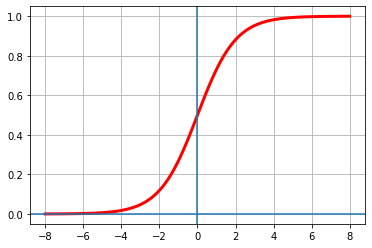

In [14]:
Xlin = np.linspace(-8,8,100)
Ysig = 1/(1+np.exp(-Xlin))
plt.plot(Xlin,Ysig, color='red', linewidth=3)
plt.grid()       # pour afficher la grille
plt.axhline()    # axe des x
plt.axvline()
plt.show()